# AutoML for Images

### Traffic Lights detection with Azure ML and AutoML for Images

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/capturelights.jpg?raw=true" width=600>

## 1. Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [2]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [3]:
#!pip install augmentor

In [4]:
import numpy as np
import json
import os
import urllib
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [5]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [6]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-07-08 07:24:09.535683


In [7]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36994775


In [8]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1047-azure',
 'Platform-version': '#49~18.04.1-Ubuntu SMP Thu Apr 22 21:28:54 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'computeinstancenbooks',
 'IP-address': '127.0.0.1',
 'MAC-address': '0d:90:a3:3d:e2:59',
 'Processor': 'x86_64',
 'RAM': '14 Go'}

## 2. Let's do some data augmentation with Augmentor

We are going to take only a few images and then do some data augmentation. We have better computet vision models if we have more images. This notebook is an example of our capabilties.
Augmentor is very easy to use for data augmentation.

> https://github.com/mdbloice/Augmentor

In [9]:
import Augmentor

In [10]:
%mkdir trafficlightimages

In [11]:
%cd trafficlightimages

/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeinstancenbooks/code/Users/seretkow/AutoML TrafficLights/trafficlightimages


In [12]:
# Let's downlaod a zip file that contains some images : 3 images for each class (red light, orange light and green light)
!wget https://github.com/retkowsky/AutoMLforImages/raw/main/images/trafficlights.zip
!unzip -qq trafficlights.zip

--2021-07-08 07:24:35--  https://github.com/retkowsky/AutoMLforImages/raw/main/images/trafficlights.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/AutoMLforImages/main/images/trafficlights.zip [following]
--2021-07-08 07:24:36--  https://raw.githubusercontent.com/retkowsky/AutoMLforImages/main/images/trafficlights.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1326269 (1.3M) [application/zip]
Saving to: ‘trafficlights.zip’

trafficlights.zip   100%[===================>]   1.26M  --.-KB/s    in 0.03s   

2021-07-08 07:24:36 (37.3 MB/s) - ‘trafficlights.zip’ saved [1326269/1326

In [13]:
%rm trafficlights.zip

In [14]:
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeinstancenbooks/code/Users/seretkow/AutoML TrafficLights


### So we have 3 images for the 3 class (red light, orange light and green light). Some images:

In [15]:
!ls trafficlightimages/*.* -l

-rwxrwxrwx 1 root root  48203 Jul  6 16:20 trafficlightimages/green1.jpg
-rwxrwxrwx 1 root root  23852 Jul  6 16:20 trafficlightimages/green2.jpg
-rwxrwxrwx 1 root root  58384 Jul  6 16:20 trafficlightimages/green3.jpg
-rwxrwxrwx 1 root root  22626 Jul  6 16:20 trafficlightimages/orange1.jpg
-rwxrwxrwx 1 root root 213579 Jul  6 16:20 trafficlightimages/orange2.jpg
-rwxrwxrwx 1 root root 112101 Jul  6 16:20 trafficlightimages/orange3.jpg
-rwxrwxrwx 1 root root 439230 Jul  6 16:20 trafficlightimages/red1.jpg
-rwxrwxrwx 1 root root  45405 Jul  6 16:20 trafficlightimages/red2.jpg
-rwxrwxrwx 1 root root 411318 Jul  6 16:20 trafficlightimages/red3.jpg


### Initial images:

Image informations:
- Image filename: trafficlightimages/green1.jpg
- Image shape: (640, 480, 3)
- Image size: 921600


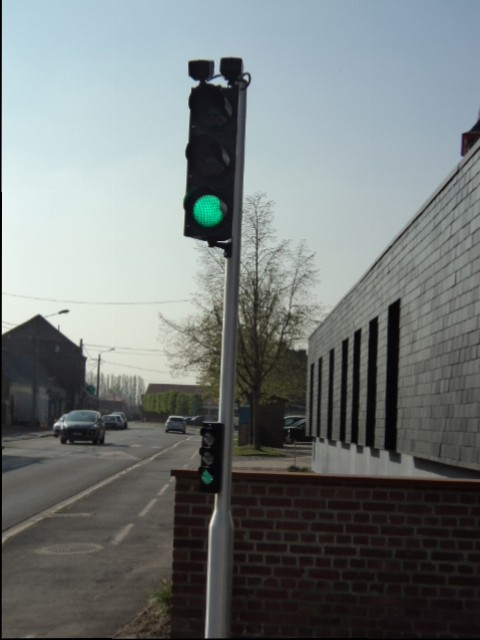

In [18]:
import cv2 as cv
image_file="trafficlightimages/green1.jpg"
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)
from IPython.display import Image
Image(filename=image_file)

Image informations:
- Image filename: trafficlightimages/red1.jpg
- Image shape: (1044, 1594, 3)
- Image size: 4992408


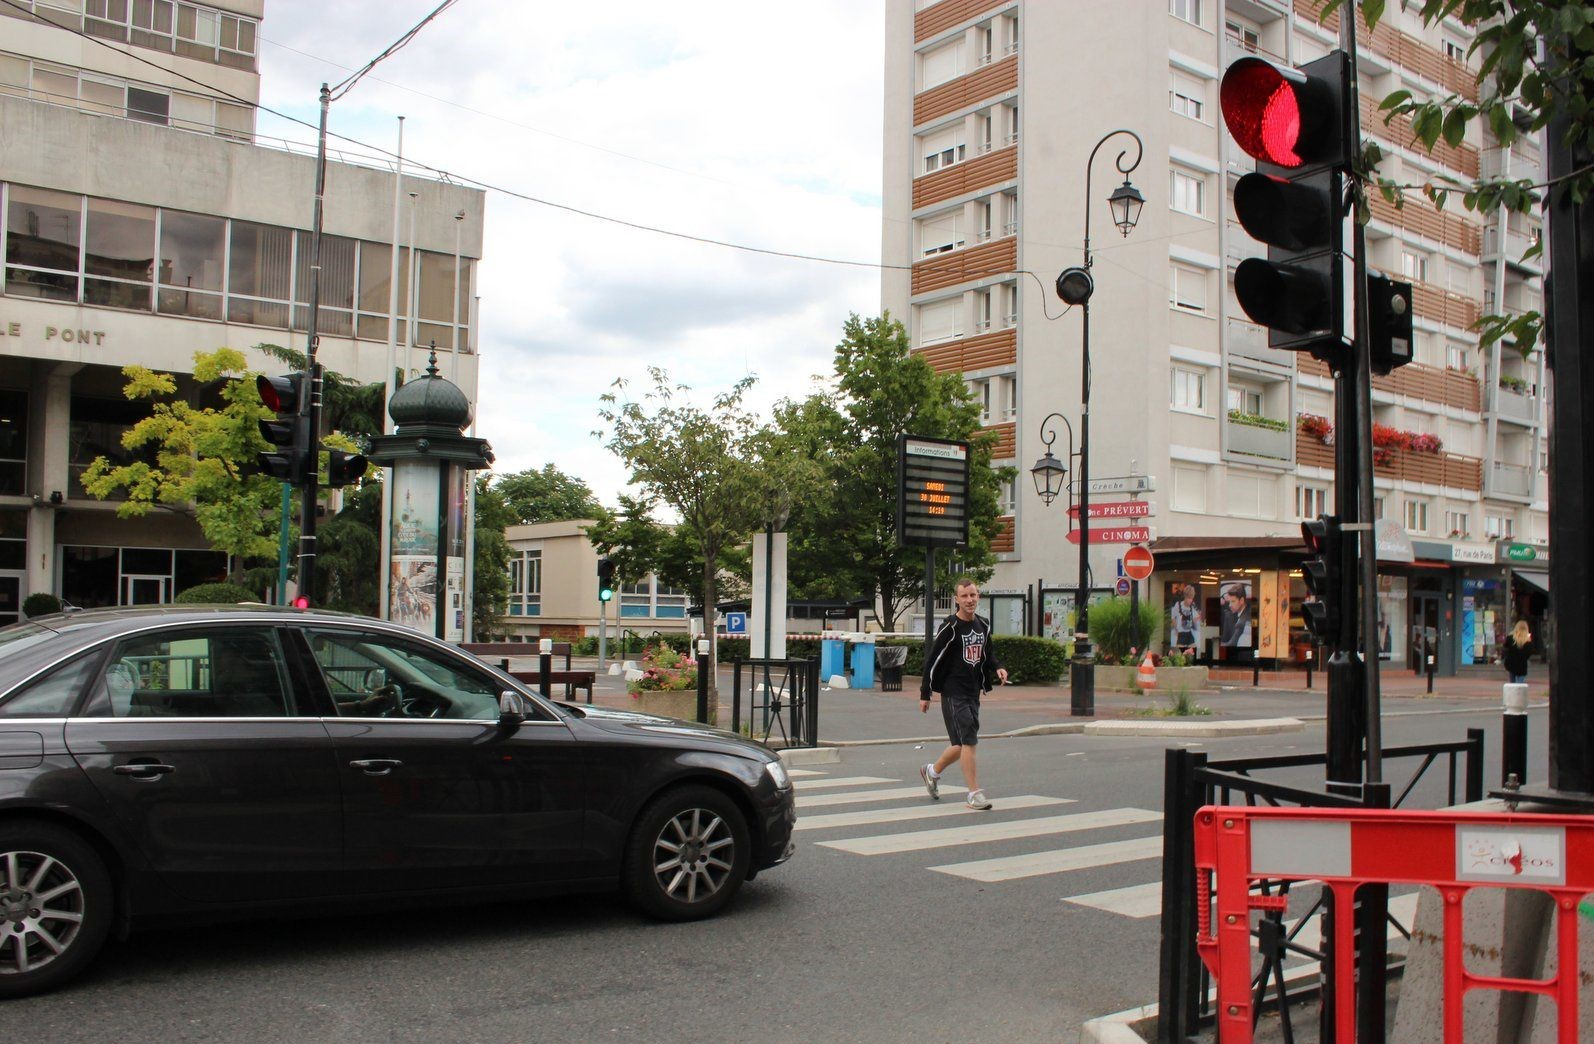

In [19]:
image_file="trafficlightimages/red1.jpg"
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)
from IPython.display import Image
Image(filename=image_file)

Image informations:
- Image filename: trafficlightimages/orange2.jpg
- Image shape: (747, 408, 3)
- Image size: 914328


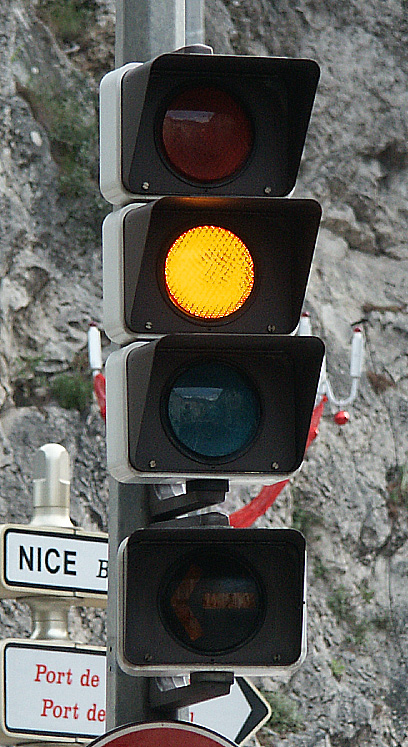

In [20]:
image_file="trafficlightimages/orange2.jpg"
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)
from IPython.display import Image
Image(filename=image_file)

### Let's do some data augmentation with Augmentor in order to have more images

In [21]:
augmentorpipeline = Augmentor.Pipeline("trafficlightimages")

augmentorpipeline.rotate(probability=0.3, max_left_rotation=15, max_right_rotation=15)
augmentorpipeline.zoom(probability=0.2, min_factor=1.1, max_factor=1)
augmentorpipeline.flip_left_right(probability=0.2)
augmentorpipeline.skew(probability=0.1)
augmentorpipeline.shear(probability=0.1, max_shear_left=0.2, max_shear_right=0.2)
augmentorpipeline.sample(150)

Executing Pipeline:   0%|          | 0/150 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to trafficlightimages/output.

Processing <PIL.Image.Image image mode=RGB size=474x632 at 0x7FB0A46EC438>: 100%|██████████| 150/150 [00:04<00:00, 36.65 Samples/s]                   


In [22]:
augmentorpipeline.status()

Operations: 5
	0: RotateRange (probability=0.3 max_left_rotation=-15 max_right_rotation=15 )
	1: Zoom (probability=0.2 min_factor=1.1 max_factor=1 )
	2: Flip (probability=0.2 top_bottom_left_right=LEFT_RIGHT )
	3: Skew (probability=0.1 skew_type=RANDOM magnitude=1 )
	4: Shear (probability=0.1 max_shear_left=0.2 max_shear_right=0.2 )
Images: 9
Classes: 1
	Class index: 0 Class label: trafficlightimages 
Dimensions: 8
	Width: 183 Height: 275
	Width: 474 Height: 632
	Width: 480 Height: 640
	Width: 1000 Height: 625
	Width: 1594 Height: 1044
	Width: 600 Height: 400
	Width: 1004 Height: 669
	Width: 408 Height: 747
Formats: 1
	 JPEG

You can remove operations using the appropriate index and the remove_operation(index) function.


### We have generated 150 images (50 new images for the 3 class to predict)

In [24]:
count=0
for root, _, files in os.walk('trafficlightimages/output'):
    count=count+len(files)
print("Total images generated =", count, "\nin the directory: trafficlightimages/output")

Total images generated = 150 
in the directory: trafficlightimages/output


In [25]:
!ls trafficlightimages/output/*.*

trafficlightimages/output/trafficlightimages_original_green1.jpg_047d0dc9-8cc8-4ce3-bd9d-1e3a7c66b7ac.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_1805e9ff-79e6-453e-a803-efe589c12f4f.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_1b70aa4f-85bc-4b3d-ab05-e19b6ceefd49.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_1d9db31a-3be1-4c1d-9916-bda941315d9e.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_28199841-103b-4f0d-b94e-4f53e397723d.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_3e90050a-1edb-44d1-b29a-2d4dba24f417.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_45954b01-7f14-48df-ac67-b80349dc8293.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_59bb403c-c5ba-4e08-a2db-7a122b7bc0ac.jpg
trafficlightimages/output/trafficlightimages_original_green1.jpg_6de5f753-d4d3-41cc-a20c-c88f696fc272.jpg
trafficlightimages/output/trafficlightimages_o

### Some results:
### This is an intial image

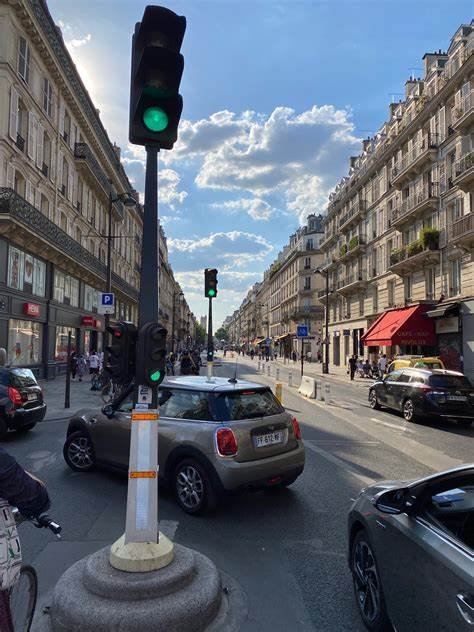

In [26]:
image_file="trafficlightimages/green3.jpg"
from IPython.display import Image
Image(filename=image_file)

### Data augmentation result

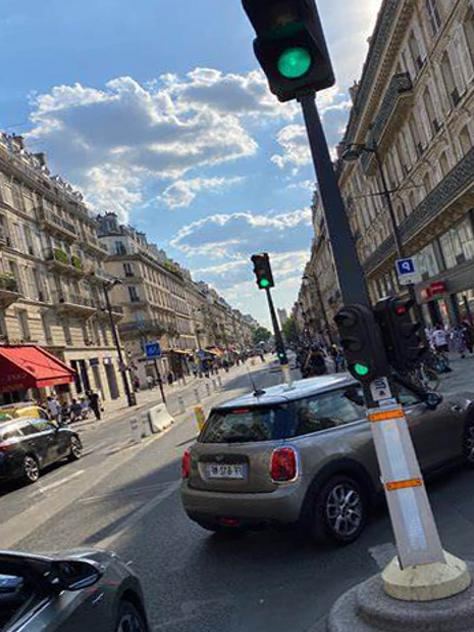

In [29]:
image_file="trafficlightimages/output/trafficlightimages_original_green3.jpg_4db20ed3-6a0d-4496-b622-7a0bd1263dbd.jpg"
from IPython.display import Image
Image(filename=image_file)

In [30]:
# We can zip all the augmented images files into a single zip file
from zipfile import ZipFile
import os
from os.path import basename

with ZipFile('augmentedimages.zip', 'w') as zipObj:
   
   for folderName, subfolders, filenames in os.walk('trafficlightimages'):
       for filename in filenames:
           filePath = os.path.join(folderName, filename)
           zipObj.write(filePath, basename(filePath))

In [31]:
!ls augmentedimages.zip -l

-rwxrwxrwx 1 root root 13135745 Jul  8 07:29 augmentedimages.zip


> Now you can save all the jpg files into an Azure Blob storage and to create an Azure ML data labelling project to tag the objects

## 3. Azure ML workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [32]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [34]:
print("Azure ML workspace:",ws.name, "\nAzure ML workspace ressource group:",ws.resource_group)

Azure ML workspace: automlvision 
Azure ML workspace ressource group: automlvision-rg


## 4. GPU Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [35]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-cluster"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=8)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Creating a new compute target...
InProgress.....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [36]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [37]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-07-08T07:31:14.209000+00:00',
 'errors': None,
 'creationTime': '2021-07-08T07:30:50.232835+00:00',
 'modifiedTime': '2021-07-08T07:31:15.937938+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 8,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [38]:
compute_target.vm_size

'STANDARD_NC6'

## 5. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [39]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-TrafficLights' 
experiment = Experiment(ws, name=experiment_name)

In [40]:
experiment

Experiment(Name: AutomlImages-TrafficLights,
Workspace: automlvision)

## 6. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In [41]:
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset
dataset = Dataset.get_by_name(ws, name='TrafficLightsLabelling_20210706_152351')
df=dataset.to_pandas_dataframe()

In [42]:
df.shape

(159, 3)

In [43]:
df.dtypes

image_url           object
label               object
label_confidence    object
dtype: object

In [44]:
df

image_url  \
0    StreamInfo(AmlDatastore://images_original_red3...   
1    StreamInfo(AmlDatastore://images_original_oran...   
2    StreamInfo(AmlDatastore://images_original_red1...   
3    StreamInfo(AmlDatastore://images_original_gree...   
4    StreamInfo(AmlDatastore://images_original_red1...   
..                                                 ...   
154  StreamInfo(AmlDatastore://red3.jpg[{'subscript...   
155  StreamInfo(AmlDatastore://images_original_gree...   
156  StreamInfo(AmlDatastore://images_original_red1...   
157  StreamInfo(AmlDatastore://orange3.jpg[{'subscr...   
158  StreamInfo(AmlDatastore://images_original_oran...   

                                                 label label_confidence  
0    [{'label': 'Red_Light', 'topX': 0.748329588457...            [1.0]  
1    [{'label': 'Orange_Light', 'topX': 0.699565774...            [1.0]  
2    [{'label': 'Red_Light', 'topX': 0.134585604558...            [1.0]  
3    [{'label': 'Green_Light', 'topX': 0.3510464123...            [1.0]  
4    [{'label': 'Red_Light', 'topX': 0.763921580773...            [1.0]  
..                                                 ...              ...  
154  [{'label': 'Red_Light', 'topX': 0.750221736045...            [1.0]  
155  [{'label': 'Green_Light', 'topX': 0.6101957070...  [1.0, 1.0, 1.0]  
156  [{'label': 'Red_Light', 'topX': 0.000789767096...            [1.0]  
157  [{'label': 'Orange_Light', 'topX': 0.778175454...       [1.0, 1.0]  
158  [{'label': 'Orange_Light', 'topX': 0.805420660...       [1.0, 1.0]  

[159 rows x 3 columns]

In [45]:
training_dataset=dataset

## 7. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://github.com/swatig007/automlForImages/blob/main/README.md) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones. 
Currently supported model algorithms for object detection:`yolov5`, `fasterrcnn_resnet50_fpn`, `fasterrcnn_resnet34_fpn`, `fasterrcnn_resnet18_fpn`, `retinanet_resnet50_fpn`.

In [46]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    'model': choice(
        {
            'model_name': choice('yolov5'),
            'learning_rate': uniform(0.0001, 0.001),
        },
        {
            'model_name': choice('fasterrcnn_resnet50_fpn'),
            'learning_rate': uniform(0.0001, 0.001),
            'optimizer': choice('sgd', 'adam', 'adamw'),
        }
    )
}

tuning_settings = {
    'iterations': 20, 
    'max_concurrent_iterations': 4, 
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)
}

automl_image_config = AutoMLImageConfig(task='image-object-detection',
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        primary_metric='mean_average_precision',
                                        **tuning_settings)

### Submitting an AutoML run for Image tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train an image model using your training dataset.

In [48]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


In [49]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_85c070b3-373a-4a3c-acd3-651d5a1e553f',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-07-08T07:34:12.90735Z',
 'endTimeUtc': '2021-07-08T08:37:52.062327Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-TrafficLights","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"automlvision-rg","workspace_name":"automlvision","region":"westeurope","compute_target":"gpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"mean_average

In [50]:
experiment

Experiment(Name: AutomlImages-TrafficLights,
Workspace: automlvision)

In [51]:
# List of all the AutoML for Images metrics values
automl_images_metrics = automl_image_run.get_metrics()
metricsdf=pd.DataFrame(automl_image_run.get_metrics())
metricsdf

precision                                  per_label_metrics  \
0     0.48019  {1: {'precision': 0.6, 'recall': 0.69231, 'ave...   
1     0.25808  {1: {'precision': 0.41935, 'recall': 0.5, 'ave...   
2     0.56492  {1: {'precision': 0.45946, 'recall': 0.65385, ...   
3     0.54487  {1: {'precision': 0.38462, 'recall': 0.57692, ...   
4     0.29210  {1: {'precision': 0.20879, 'recall': 0.73077, ...   
5     0.29110  {1: {'precision': 0.52632, 'recall': 0.76923, ...   
6     0.32717  {1: {'precision': 0.45283, 'recall': 0.92308, ...   
7     0.56695  {1: {'precision': 0.58974, 'recall': 0.88462, ...   
8     0.58677  {1: {'precision': 0.69444, 'recall': 0.96154, ...   
9     0.49398  {1: {'precision': 0.72222, 'recall': 1.0, 'ave...   
10    0.68884  {1: {'precision': 0.71429, 'recall': 0.96154, ...   
11    0.77351  {1: {'precision': 0.83871, 'recall': 1.0, 'ave...   
12    0.70990  {1: {'precision': 0.75, 'recall': 0.92308, 'av...   
13    0.83198  {1: {'precision': 0.80645, 'recall': 0.96154, ...   
14    0.82477  {1: {'precision': 0.86667, 'recall': 1.0, 'ave...   

    mean_average_precision   recall  
0                  0.39509  0.56873  
1                  0.55274  0.73843  
2                  0.49937  0.63925  
3                  0.51234  0.60203  
4                  0.57935  0.82692  
5                  0.63340  0.83974  
6                  0.83110  0.93269  
7                  0.79089  0.84117  
8                  0.85634  0.89227  
9                  0.91291  0.95833  
10                 0.86473  0.90848  
11                 0.92471  0.94213  
12                 0.91709  0.93269  
13                 0.95806  0.96635  
14                 0.97138  0.97917

In [52]:
metricsdf.sort_values(by='mean_average_precision', ascending=False)

precision                                  per_label_metrics  \
14    0.82477  {1: {'precision': 0.86667, 'recall': 1.0, 'ave...   
13    0.83198  {1: {'precision': 0.80645, 'recall': 0.96154, ...   
11    0.77351  {1: {'precision': 0.83871, 'recall': 1.0, 'ave...   
12    0.70990  {1: {'precision': 0.75, 'recall': 0.92308, 'av...   
9     0.49398  {1: {'precision': 0.72222, 'recall': 1.0, 'ave...   
10    0.68884  {1: {'precision': 0.71429, 'recall': 0.96154, ...   
8     0.58677  {1: {'precision': 0.69444, 'recall': 0.96154, ...   
6     0.32717  {1: {'precision': 0.45283, 'recall': 0.92308, ...   
7     0.56695  {1: {'precision': 0.58974, 'recall': 0.88462, ...   
5     0.29110  {1: {'precision': 0.52632, 'recall': 0.76923, ...   
4     0.29210  {1: {'precision': 0.20879, 'recall': 0.73077, ...   
1     0.25808  {1: {'precision': 0.41935, 'recall': 0.5, 'ave...   
3     0.54487  {1: {'precision': 0.38462, 'recall': 0.57692, ...   
2     0.56492  {1: {'precision': 0.45946, 'recall': 0.65385, ...   
0     0.48019  {1: {'precision': 0.6, 'recall': 0.69231, 'ave...   

    mean_average_precision   recall  
14                 0.97138  0.97917  
13                 0.95806  0.96635  
11                 0.92471  0.94213  
12                 0.91709  0.93269  
9                  0.91291  0.95833  
10                 0.86473  0.90848  
8                  0.85634  0.89227  
6                  0.83110  0.93269  
7                  0.79089  0.84117  
5                  0.63340  0.83974  
4                  0.57935  0.82692  
1                  0.55274  0.73843  
3                  0.51234  0.60203  
2                  0.49937  0.63925  
0                  0.39509  0.56873

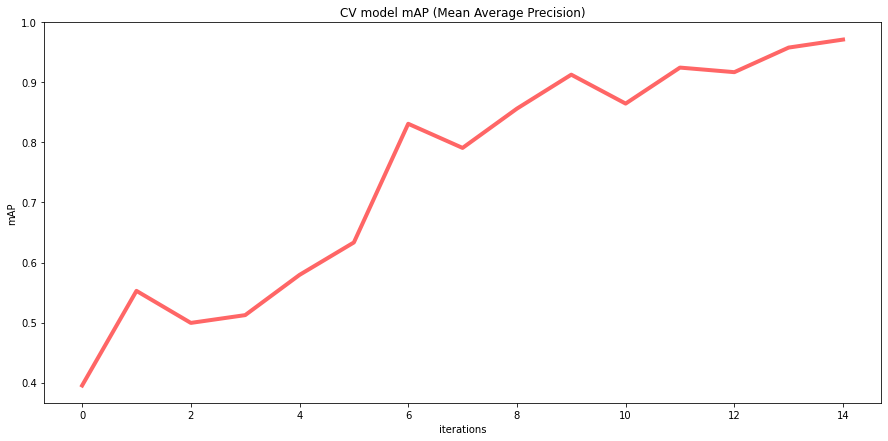

In [53]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (15,7))
plt.plot(automl_images_metrics['mean_average_precision'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('mAP', fontsize=10)
plt.title('CV model mAP (Mean Average Precision)', fontsize=12)
plt.savefig('mAP.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='mAP.jpg', plot=plt) # Logging the graph into the Azure ML experiment
plt.show()

In [54]:
# Checking the file
!ls mAP.jpg -l

-rwxrwxrwx 1 root root 102567 Jul  8 08:38 mAP.jpg


## 8. Register the optimal model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [55]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Traffic Light Detection",
              "Computer Vision" : "True",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "mAP"}

In [56]:
# Register the model from the best run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name, 
                                      model_path='outputs/model.pt',
                                      tags=cvmodel_tags,
                                      description="Traffic Light Detection")

In [59]:
model

Model(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=AutoML85c070b331, id=AutoML85c070b331:1, version=1, tags={'Data': 'Images', 'Context': 'Traffic Light Detection', 'Computer Vision': 'True', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'mAP'}, properties={})

In [60]:
model.id

'AutoML85c070b331:1'

In [61]:
model.tags

{'Data': 'Images',
 'Context': 'Traffic Light Detection',
 'Computer Vision': 'True',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'mAP'}

In [62]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)
!ls model.pt -l

-rwxrwxrwx 1 root root 494512222 Jul  8 08:40 model.pt


## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster, or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [63]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target. So let's use it")
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="westeurope")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target. So let's use it
CPU times: user 16.5 ms, sys: 4.67 ms, total: 21.2 ms
Wall time: 306 ms


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [64]:
%%time
# Deploy the model from the best run as an AKS web service
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

aks_name='automltrafficlight'

aks_tags={"Data": "Images", 
          "Topic" : "Custom Vision model", 
          'Task' : 'Traffic light Detection',
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

aks_description="Object Detection CV model to detect Traffic light"

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=aks_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)
print("\nDone. Model is deployed.")
print("AKS service status=", aks_service.state)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-07-08 08:42:07+00:00 Creating Container Registry if not exists.
2021-07-08 08:42:07+00:00 Registering the environment.
2021-07-08 08:42:08+00:00 Use the existing image.
2021-07-08 08:42:10+00:00 Checking the status of deployment automltrafficlight..
2021-07-08 08:45:00+00:00 Checking the status of inference endpoint automltrafficlight.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed.
AKS service status= Healthy


> It usually took less than 10 minutes to deploy the computer vision model.

## 9. Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to te scoring URI.

In [65]:
print("Computer vision deployed model:\n")
print("- Endpoint:", aks_service.scoring_uri)
print("- Status=", aks_service.state)
print("- Properties:", aks_service.properties)
print("- Tags:", aks_service.tags)

Computer vision deployed model:

- Endpoint: http://20.86.224.235:80/api/v1/service/automltrafficlight/score
- Status= Healthy
- Properties: {'hasInferenceSchema': 'False', 'hasHttps': 'False'}
- Tags: {'Data': 'Images', 'Topic': 'Custom Vision model', 'Task': 'Traffic light Detection', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


In [321]:
def mycvmodel(image_url, level):
    import urllib 
    import os
    jpgfilename = os.path.basename(image_url)
    sub_string = "jpg"
    image_file = jpgfilename[:jpgfilename.index(sub_string) + len(sub_string)]
    prediction_file="prediction_"+image_file
    print("Downloading image", image_url)
    urllib.request.urlretrieve(image_url, filename=image_file)
    print("Done!")
    print("Local image file:", image_file)

    import cv2 as cv
    img = cv.imread(image_file)
    print("\nImage informations:")
    print("- Image filename:", image_file)
    print("- Image shape:", img.shape)
    print("- Image size:", img.size)

    import requests
    # URL for the web service
    scoring_uri = aks_service.scoring_uri
    # If the service is authenticated, set the key or token
    key, _ = aks_service.get_keys()
    # Load image data
    data = open(image_file, 'rb').read()
    # Set the content type
    headers = {'Content-Type': 'application/octet-stream'}
    # If authentication is enabled, set the authorization header
    headers['Authorization'] = f'Bearer {key}'
    # Make the request and display the response
    resp = requests.post(scoring_uri, data, headers=headers)
    print("\nCalling the AKS deployed model.")
    print("Status code=",resp.status_code)
    print("Elapsed=", resp.elapsed)
    print("\nComputer vision results:")
    print(resp.text)
    
    import json
    detections = json.loads(resp.text) # Loading the predictions from the computer vision model
    for detect in detections['boxes']:
        label = detect['label']
        box = detect['box']
        conf_score = detect['score']
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import matplotlib.patches as patches
    from PIL import Image
    import numpy as np
    import json

    IMAGE_SIZE = (18,12)
    plt.figure(figsize=IMAGE_SIZE)
    img_np=mpimg.imread(image_file)
    img = Image.fromarray(img_np.astype('uint8'),'RGB')
    x, y = img.size
    fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

    # Display the image
    ax.imshow(img_np)
    minscore=level # Level
    
    # draw box and label for each detection 
    detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
    nbtags=detections['boxes']
    print("\033[1;31;34mNumber of objects detected =", len(nbtags),"\n")
    print("Predicted objects with probability >=", level, ":")
    
    for detect in detections['boxes']:
        label = detect['label']
        box = detect['box']
        conf_score = detect['score']

        if conf_score >= minscore: #Min probability
            ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
            topleft_x, topleft_y = x * xmin, y * ymin
            width, height = x * (xmax - xmin), y * (ymax - ymin)
            print('   {} = Region : [{}, {}, {}, {}] Probability = {}'.format(detect['label'], round(topleft_x, 3), 
                                                    round(topleft_y, 3), round(width, 3), 
                                                    round(height, 3), round(conf_score, 4)))
            if label=="Green_Light":
                label="Green Light"
                color="lime"
                backgroundcolor="green"
            if label=="Orange_Light":
                label="Orange Light"
                color="orange"
                backgroundcolor="red"
            if label=="Red_Light":
                label="Red Light"
                color="red"
                backgroundcolor="orange"
        
            rect = patches.Rectangle((topleft_x, topleft_y), width, height, linewidth=3, edgecolor=color,facecolor='none')
            textdisp=(label+'='+str(round(conf_score, 2)))
            ax.add_patch(rect)
            plt.text(topleft_x, topleft_y - 10, textdisp, color=color, backgroundcolor=backgroundcolor, fontsize=15)       
            fig.savefig(prediction_file, dpi=150) #Saving image
        
    plt.show()

Done!
Local image file: testlight1.jpg

Image informations:
- Image filename: testlight1.jpg
- Image shape: (2268, 4032, 3)
- Image size: 27433728

Calling the AKS deployed model.
Status code= 200
Elapsed= 0:00:00.703323

Computer vision results:
{"filename": "/tmp/tmpitibw6u3", "boxes": [{"box": {"topX": 0.7591233244532716, "topY": 0.4559821065266927, "bottomX": 0.7834891771957082, "bottomY": 0.5596014912923177}, "label": "Green_Light", "score": 0.993671178817749}, {"box": {"topX": 0.6078128206349672, "topY": 0.2367521667480469, "bottomX": 0.629039198998886, "bottomY": 0.3174828592936198}, "label": "Green_Light", "score": 0.9894193410873413}, {"box": {"topX": 0.41921410193810094, "topY": 0.2580730692545573, "bottomX": 0.4381926574134469, "bottomY": 0.33883824666341145}, "label": "Green_Light", "score": 0.8067017793655396}]}

Number of objects detected = 3 

Predicted objects with probability >= 0.7 :
   Green_Light = Region : [3060.785, 1034.167, 98.243, 235.009] Probability = 0.9937


<Figure size 1296x864 with 0 Axes>

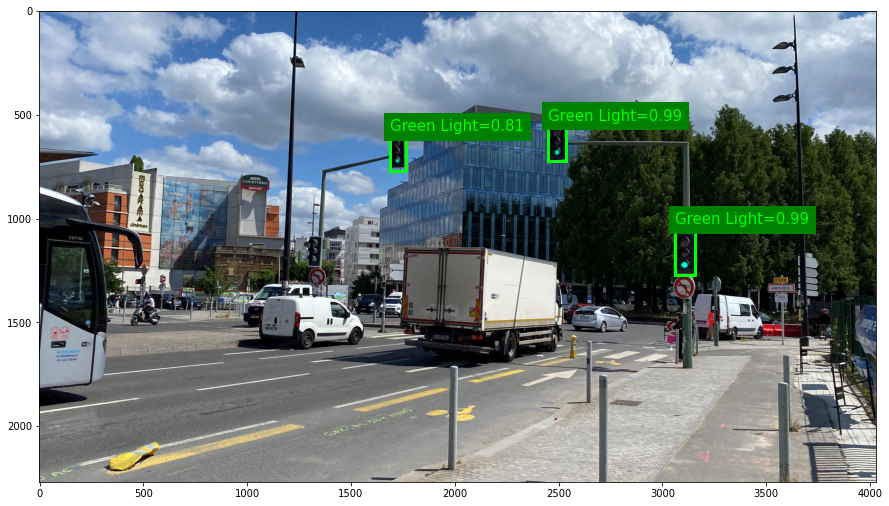

In [322]:
mycvmodel('https://github.com/retkowsky/AutoMLforImages/blob/main/images/testlight1.jpg?raw=true', 0.7)

Done!
Local image file: testlight2.jpg

Image informations:
- Image filename: testlight2.jpg
- Image shape: (2261, 3108, 3)
- Image size: 21081564

Calling the AKS deployed model.
Status code= 200
Elapsed= 0:00:00.570914

Computer vision results:
{"filename": "/tmp/tmp6812__ij", "boxes": [{"box": {"topX": 0.6051636482905416, "topY": 0.5471915690104167, "bottomX": 0.6285822599836923, "bottomY": 0.6331908162434896}, "label": "Orange_Light", "score": 0.9751365184783936}, {"box": {"topX": 0.35740602363660495, "topY": 0.3103699493408203, "bottomX": 0.3840216479255158, "bottomY": 0.384291254679362}, "label": "Orange_Light", "score": 0.8849595785140991}, {"box": {"topX": 0.17680527400044563, "topY": 0.6420975240071615, "bottomX": 0.21087792776163342, "bottomY": 0.7589889017740885}, "label": "Green_Light", "score": 0.4934160113334656}]}

Number of objects detected = 3 

Predicted objects with probability >= 0.7 :
   Orange_Light = Region : [1880.849, 1237.2, 72.785, 194.444] Probability = 0.97

<Figure size 1296x864 with 0 Axes>

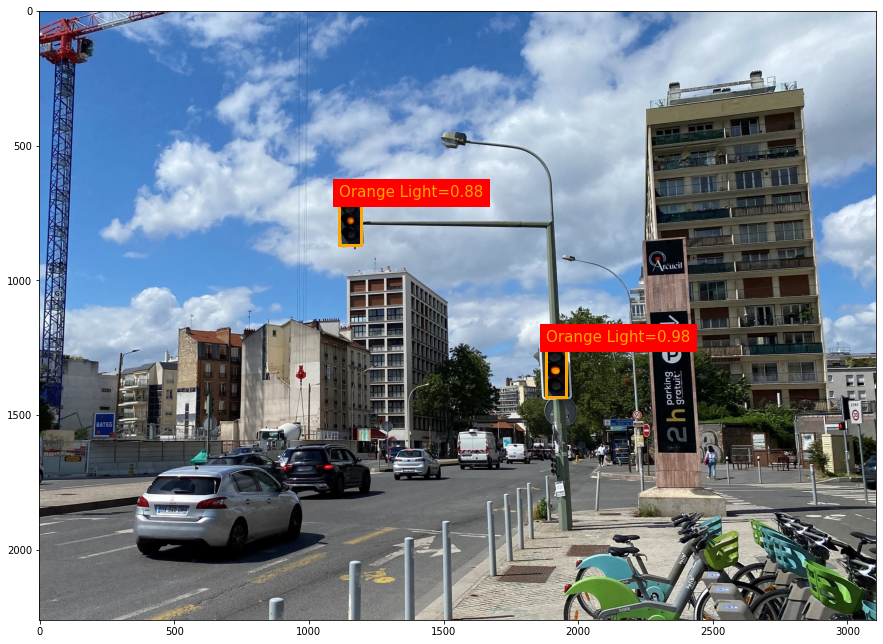

In [323]:
mycvmodel('https://github.com/retkowsky/AutoMLforImages/blob/main/images/testlight2.jpg?raw=true', 0.7)

Done!
Local image file: testlight5.jpg

Image informations:
- Image filename: testlight5.jpg
- Image shape: (704, 1070, 3)
- Image size: 2259840

Calling the AKS deployed model.
Status code= 200
Elapsed= 0:00:00.327006

Computer vision results:
{"filename": "/tmp/tmph1g0egvw", "boxes": [{"box": {"topX": 0.11736234796819257, "topY": 0.23251739501953125, "bottomX": 0.14221193081199404, "bottomY": 0.31677164713541667}, "label": "Green_Light", "score": 0.9722756743431091}, {"box": {"topX": 0.7602352808126372, "topY": 0.3060468037923177, "bottomX": 0.7803019786378294, "bottomY": 0.3696252950032552}, "label": "Green_Light", "score": 0.9082030057907104}]}

Number of objects detected = 2 

Predicted objects with probability >= 0.7 :
   Green_Light = Region : [125.578, 163.692, 26.589, 59.315] Probability = 0.9723
   Green_Light = Region : [813.452, 215.457, 21.471, 44.759] Probability = 0.9082


<Figure size 1296x864 with 0 Axes>

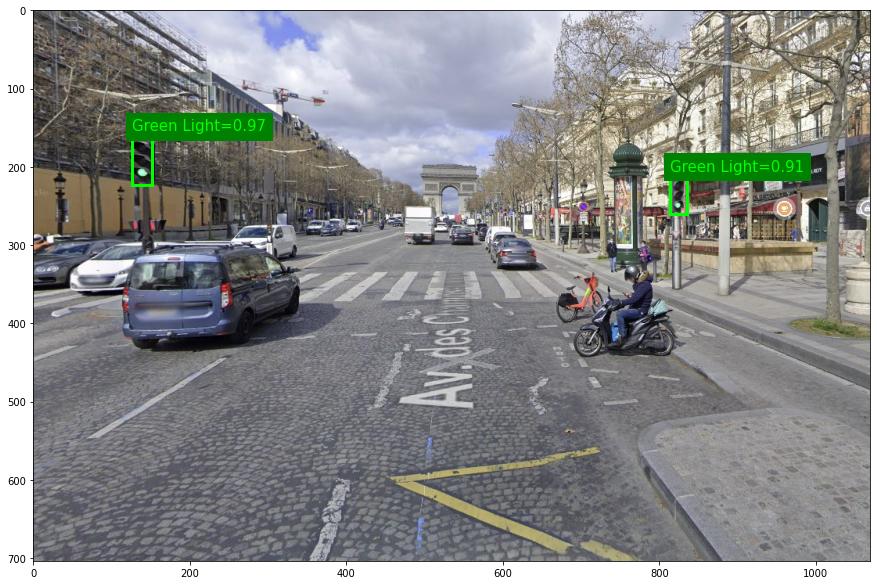

In [324]:
mycvmodel('https://github.com/retkowsky/AutoMLforImages/blob/main/images/testlight5.jpg?raw=true', 0.7)

Done!
Local image file: testlight6.jpg

Image informations:
- Image filename: testlight6.jpg
- Image shape: (766, 887, 3)
- Image size: 2038326

Calling the AKS deployed model.
Status code= 200
Elapsed= 0:00:00.328211

Computer vision results:
{"filename": "/tmp/tmp3nszvd_x", "boxes": [{"box": {"topX": 0.1493669999092388, "topY": 0.29306912740071617, "bottomX": 0.17586434883755292, "bottomY": 0.3629895273844401}, "label": "Green_Light", "score": 0.9407891035079956}, {"box": {"topX": 0.7900720425916337, "topY": 0.3509966278076172, "bottomX": 0.8088516982900307, "bottomY": 0.3989749399820964}, "label": "Green_Light", "score": 0.7737107276916504}, {"box": {"topX": 0.7820266591712446, "topY": 0.34493479410807293, "bottomX": 0.8170675228239823, "bottomY": 0.4006387329101562}, "label": "Green_Light", "score": 0.3514595329761505}]}

Number of objects detected = 3 

Predicted objects with probability >= 0.7 :
   Green_Light = Region : [132.489, 224.491, 23.503, 53.559] Probability = 0.9408
   

<Figure size 1296x864 with 0 Axes>

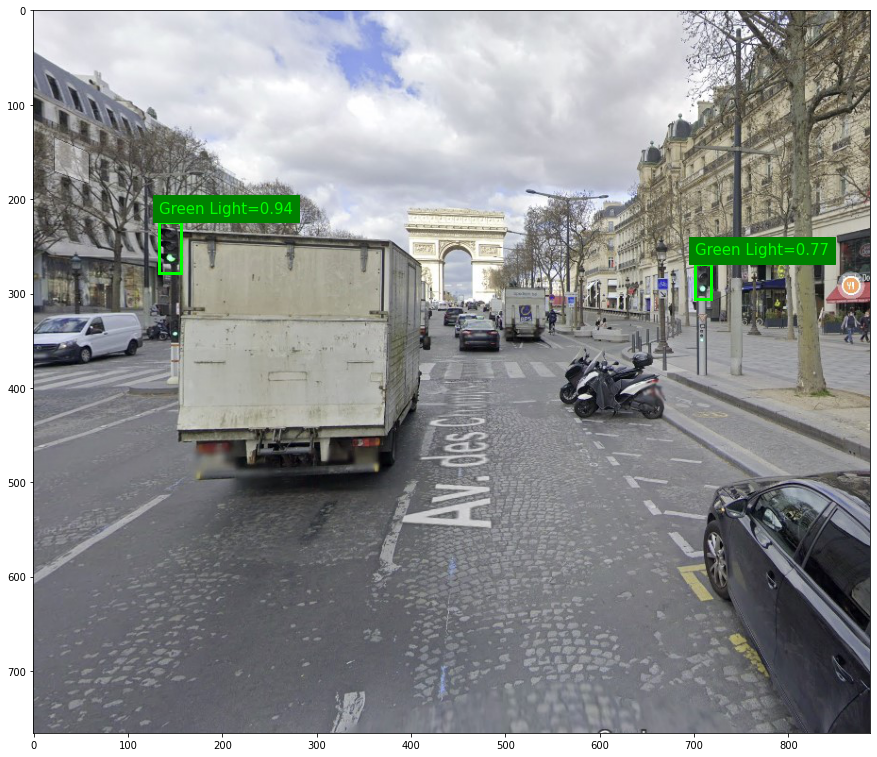

In [325]:
mycvmodel('https://github.com/retkowsky/AutoMLforImages/blob/main/images/testlight6.jpg?raw=true', 0.7)

Done!
Local image file: testlight7.jpg

Image informations:
- Image filename: testlight7.jpg
- Image shape: (642, 1747, 3)
- Image size: 3364722

Calling the AKS deployed model.
Status code= 200
Elapsed= 0:00:00.374709

Computer vision results:
{"filename": "/tmp/tmpx4v1_9ky", "boxes": [{"box": {"topX": 0.6091775171576097, "topY": 0.11151002911214691, "bottomX": 0.6282275372309875, "bottomY": 0.23040919703696158}, "label": "Red_Light", "score": 0.8056378960609436}]}

Number of objects detected = 1 

Predicted objects with probability >= 0.7 :
   Red_Light = Region : [1064.233, 71.589, 33.28, 76.333] Probability = 0.8056


<Figure size 1296x864 with 0 Axes>

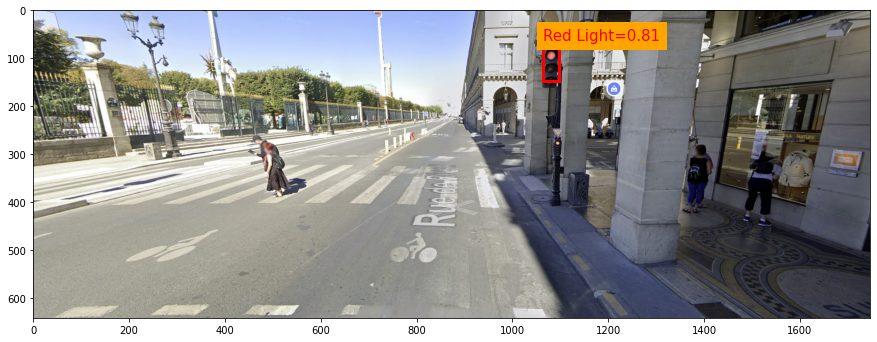

In [326]:
mycvmodel('https://github.com/retkowsky/AutoMLforImages/blob/main/images/testlight7.jpg?raw=true', 0.7)

## 10. Cleanup ressources

In [ ]:
#aks_service.delete()
#compute_target.delete()

> End of Notebook